# Retrosynthesis

[Retrosynthesis](https://en.wikipedia.org/wiki/Retrosynthetic_analysis) predicts what molecules were used to produce (or synthesize) a given chemical. It's like if I showed you a cake, then you would say "I need flour, water, eggs, sugar, baking soda, butter, and salt to create that cake." 

[E. J. Corey](https://en.wikipedia.org/wiki/Elias_James_Corey) was awarded the [1990 Nobel Prize in Chemistry](https://www.nobelprize.org/prizes/chemistry/1990/summary/) for his work in "organic synthesis" (which includes retrosynthesis). There are many variations on recipes to make a cake (even if you use the same ingredients). Similarly, retrosynthesis algorithms help chemists identify new (and possibly easier/cheaper/faster) methods of creating drugs for the pharmaceutical industry.

In this notebook, we'll attempt to build a machine learning model for retrosynthesis predictions.  
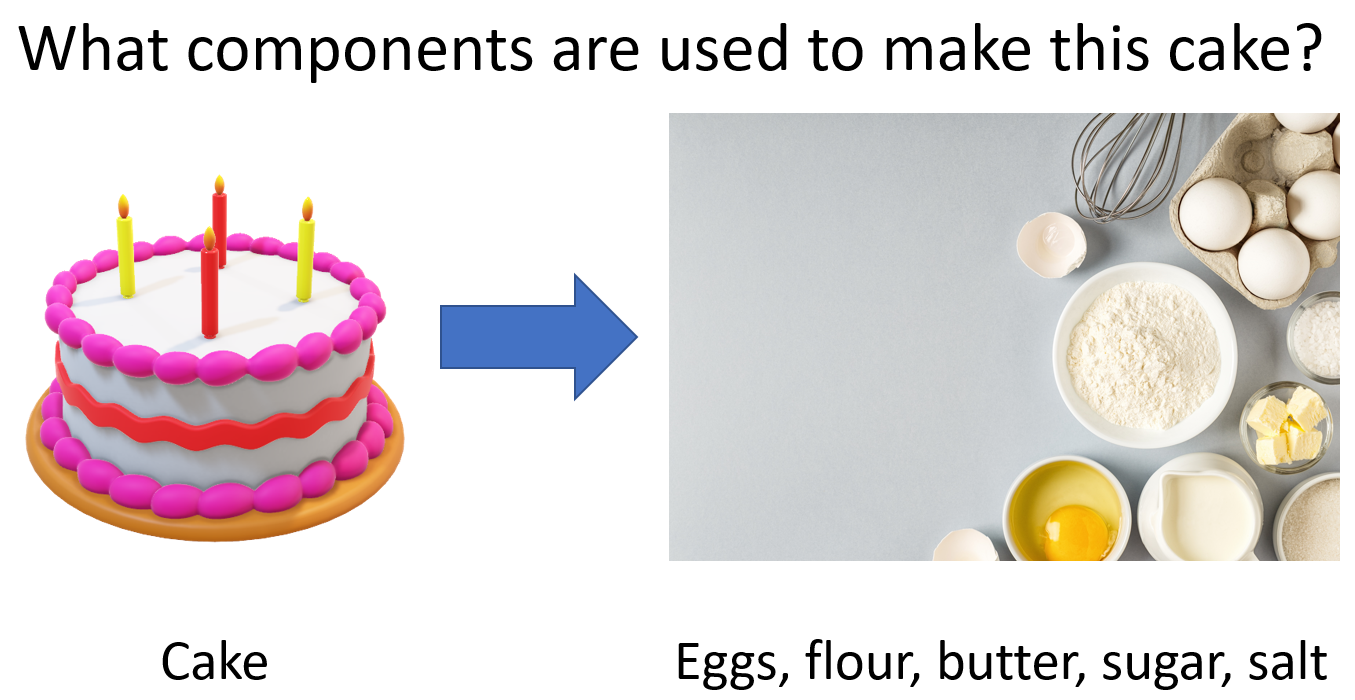

## RD-Kit - Python for Chemistry

[RD-Kit](https://www.rdkit.org/) is an open-source (BSD-3) Python package for data scientists to work with Chemistry data. It has some excellent modules that allow us to preprocess data from chemistry experiments.

You can install it using the conda package: `conda install -c rdkit rdkit`

In [1]:
from rdkit import Chem 
from rdkit.Chem import AllChem

RDKit WARNING: [15:12:32] Enabling RDKit 2019.09.3 jupyter extensions


## SMILES format

[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) stands for the **S**implified **M**olecular **I**nput **L**ine **E**ntry **S**ystem which is a method for describing the structure of chemical species using short ASCII strings. Essentially it's a short-hand notation for describing a molecule including information about which atoms are connected together, the types of chemical bonds, and the 2D structure. In SMILES notation, 'C' represents a carbon atom, 'N' represents a nitrogen atom, 'Cl' represents a Chlorine atom, and '=' indicates a double bond between the adjacent atoms. 

A good resource for learning about SMILES notation is:

Quirós, M., Gražulis, S., Girdzijauskaitė, S. et al. Using SMILES strings for the description of chemical connectivity in the Crystallography Open Database. J Cheminform 10, 23 (2018). https://doi.org/10.1186/s13321-018-0279-6

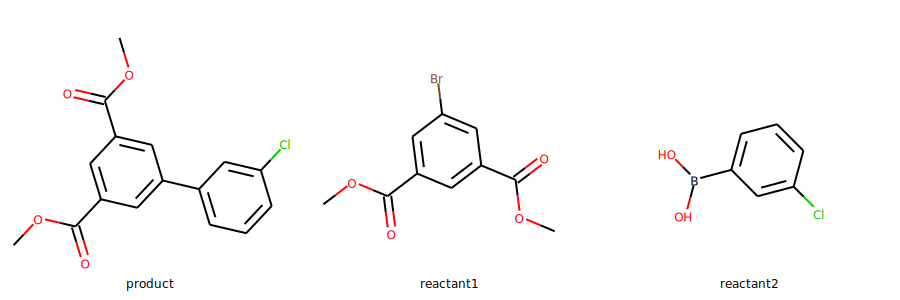

In [2]:
product = "COC(=O)c1cc(C(=O)OC)cc(-c2cccc(Cl)c2)c1"
reactant1 = "COC(=O)c1cc(Br)cc(C(=O)OC)c1"
reactant2 = "OB(O)c1cccc(Cl)c1"

vector = [Chem.MolFromSmiles(product), Chem.MolFromSmiles(reactant1), Chem.MolFromSmiles(reactant2)]

Chem.Draw.MolsToGridImage(vector, molsPerRow=3, 
                                     useSVG=True, 
                                     legends=["product", "reactant1", "reactant2"], 
                                     subImgSize=(300, 300))

## Chemical reactions

In the figure above, we show the SMILES notations of 3 molecules and the 2D structure: 

| Type | SMILES Notation |
| ---- | ----|
| Product | COC(=O)c1cc(C(=O)OC)cc(-c2cccc(Cl)c2)c1 |
|Reactant 1 | COC(=O)c1cc(Br)cc(C(=O)OC)c1 |
| Reactant 2| OB(O)c1cccc(Cl)c1 |

To write the entire equation we use `>>` for the chemical reactions and `.` to separate SMILES notations of different molecules.

e.g. `COC(=O)c1cc(C(=O)OC)cc(-c2cccc(Cl)c2)c1 >> COC(=O)c1cc(Br)cc(C(=O)OC)c1.OB(O)c1cccc(Cl)c1`

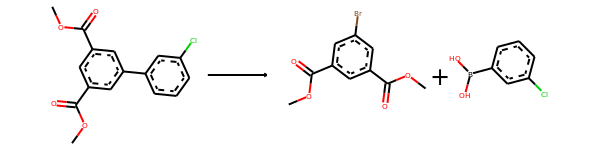

In [3]:
reaction = product + " >> " + reactant1 + "." + reactant2

AllChem.ReactionFromSmarts(reaction, useSmiles=True)

## Read and parse the data file

The data was taken from Igor Tetko's [BigChem](https://github.com/bigchem/retrosynthesis/tree/master/data) GitHub repository. The paper is [here](https://link.springer.com/chapter/10.1007/978-3-030-30493-5_78). This data comes from the [USA Open Source Patent Database](https://pubs.acs.org/doi/10.1021/acscentsci.7b00303) which was extracted by text-mining from United States patents published between 1976 and September 2016. More information can be found by contacting [Daniel Lowe of NextMove Software](https://depth-first.com/articles/2019/01/28/the-nextmove-patent-reaction-dataset/). The data is released under the [CC0](https://creativecommons.org/publicdomain/zero/1.0/) open source license.

The data file is simply the reactions in SMILES notation.

```
product1.product2.product3 >> reactant1.reactant2.reactant3.reactant4.reactant5
product1.product6.product7 >> reactant8.reactant2.reactant45.reactant4.reactant5
product3.product4.product7 >> reactant22.reactant8.reactant9.reactant2.reactant5
...
```

For example,

```
O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1 >> CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl
Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1 >> COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1
CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C >> CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.FC(F)(F)c1ccnc(Nc2cccc(Br)c2)n1
CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O >> CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1
Fc1cc2c(NC3CCCCCC3)ncnc2cn1 >> Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1
...
```

We can load it into a [pandas](https://pandas.pydata.org/) dataframe.

In [4]:
import pandas as pd  # Import pandas `pip install pandas` or `conda install pandas`

df = pd.read_csv("data/retrosynthesis-train.smi", 
                 delimiter=">>", # Delimiter between products and reactants
                 header=None, 
                 engine="python",
                 names=["product", "reactants"])

df["product"].str.strip();  # Strip any leading or trailing whitespace
df["reactants"].str.strip();

In [5]:
df

,product,reactants
0,O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)...,CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc...
1,Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1,COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1
2,CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C,CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.FC(F)(F)...
3,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1
4,Fc1cc2c(NC3CCCCCC3)ncnc2cn1,Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1
...,...,...
40024,CCCn1cc(CC)nc1-c1cnc(Nc2ccc(Cl)cc2)c(Cl)c1,CCCI.CCc1c[nH]c(-c2cnc(Nc3ccc(Cl)cc3)c(Cl)c2)n1
40025,COc1ccc2nccc(N3C[C@@H]4C[C@H]3CN4CCN)c2n1,COc1ccc2nccc(N3C[C@@H]4C[C@H]3CN4CCNC(=O)OCc3...
40026,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4NC4CCN(Cc5c...,CCOC(=O)C1(c2ccc(B3OC(C)(C)C(C)(C)O3)cc2)CC1....
40027,COC(=O)c1ncc(NS(=O)(=O)c2ccncc2)cc1F,COC(=O)c1ncc(Br)cc1F.NS(=O)(=O)c1ccncc1


## What is our goal?

We'd like to create an algorithm f(x) that takes the can accurately predict the reactants if we input the product.

For example, 

`f( "COC(=O)c1cc(F)c(F)cc1Br" ) = "C=[N+]=[N-].O=C(O)c1cc(F)c(F)cc1Br"`

We can do this with machine learning.

## Create a column with the Mol object

With RD-Kit we can transform the SMILES notation into a more useful Python object called a *Mol* (for molecule). Mol objects contain the atoms, bonds, connectivity and coordinates of a molecule. It adds important 3D information, such as the distance between atoms, that may be useful to our model. We can use Mol objects to craft features of the chemical to provide as inputs to our model.

In [6]:
df['product_mol'] = df['product'].apply(lambda x: Chem.MolFromSmiles(x))  # Create Mol objects from the SMILES notation

## Online augmentation of data

Deep learning often uses [online augmentation](https://en.wikipedia.org/wiki/Data_augmentation) of the input data to increase the number of training examples and make the model more robust to slight changes. For example, a picture of a cat (below) is still a cat if the cat is not in the center of the picture or the contrast is slightly changed or we zoom in and out on the cat. 

Interestingly, the SMILES notation actually has this ["feature" built in](http://opensmiles.org/spec/open-smiles-4-output.html). If I look at a molecule and want to write a long string to represent this 3D structure, then what atom should be position 1 and should I move left/right/up/down through the structure? There's no right answer. It's like listing the rooms in a house by the sequence ("entry", "kitchen", "living room", "bedroom 1", "bedroom 2", "bathroom"). I could also reverse the sequence ("bathroom", "bedroom 2", "bedroom 1", "living room", "kitchen", "entry") and still be moving along the same path in the same house. So any rotation of the SMILES notation order may yield the same molecule.

Additionally, if I have a functional group (e.g. a hydroxyl), the order doesn't really matter (e.g. "OH" or "HO" are the same). So in substructures there are even places where the order doesn't necessarily matter.

Fortunately, RD-Kit allows us to automate this by just allowing us to convert a SMILES into Mol and then back into SMILES, but keep a flag called ["doRandom"](http://rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolToSmiles) enabled. The figure below shows SMILES for randomizations. It's essentially the same structure.

(NOTE: There definitely are differences, such as chirality, that can affect function. So there's probably more to do than just this simple first pass of online augmentation.)

(NOTE: There seems to be a new function (which isn't implemented on my RD-Kit version) that generates a vector of random SMILES.)

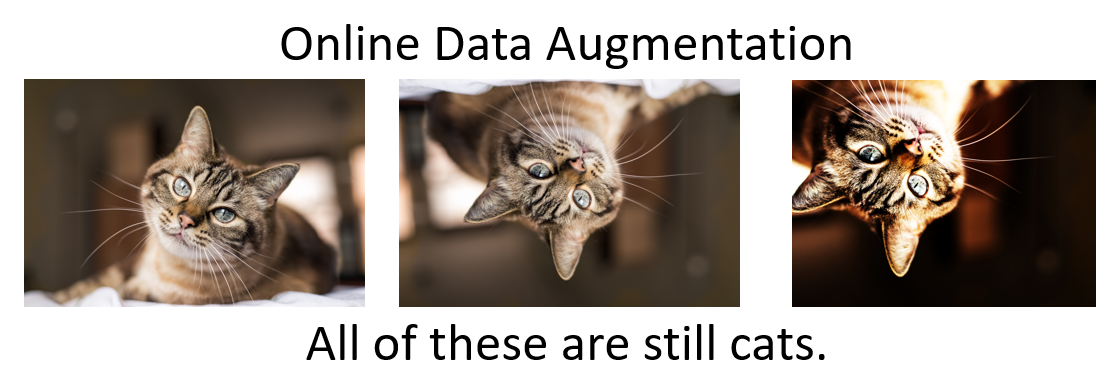

In [7]:
def create_random_smiles(mol, show=False):
    """
    Create a SMILES from the mol object.
    There are multiple SMILES that generate the same molecule. Usually, it's a rotation of the sequence.
    """
    
    smiles = Chem.MolToSmiles(mol, doRandom=True)
    
    if show:
        display(Chem.MolFromSmiles(smiles))
        
    return smiles

In [8]:
def show_random_smiles_are_same(mol, number=10):
    """
    Show a few randomly augmented SMILES from the same molecule
    """
    
    vector = []
    labels = []
    for _ in range(number):
        label = Chem.MolToSmiles(mol, doRandom=True)
        labels.append(label)
        vector.append(Chem.MolFromSmiles(label))
        
    return Chem.Draw.MolsToGridImage(vector, 
                                     molsPerRow=2, 
                                     useSVG=True, 
                                     legends=labels, 
                                     subImgSize=(300, 300))

## Example of SMILES augmentation

All of these are the same molecule but have different SMILES notations! They are the chemical equivalent of rotation, zooming, and contrast changes on our cat picture.

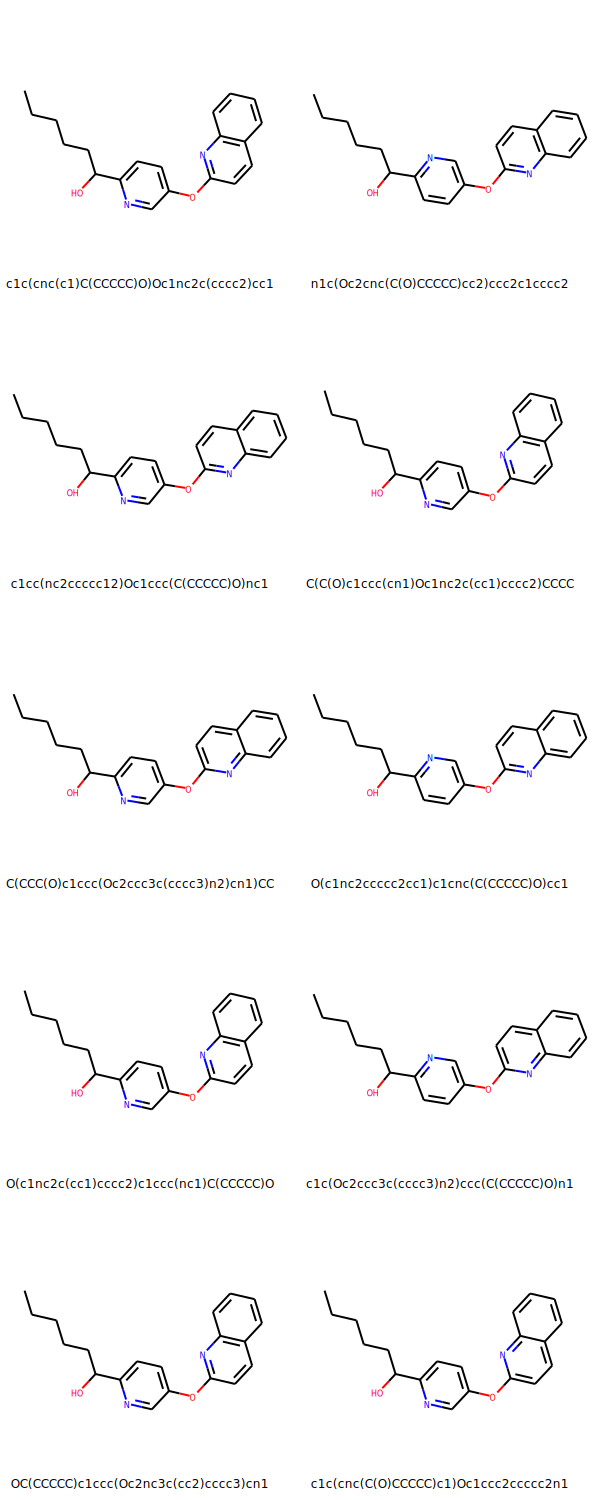

In [9]:
mol = df["product_mol"].iloc[10]  # Pick one
show_random_smiles_are_same(mol, number=10)